final1(87.31)에서 feature 선택을 바꿈

# 목차
1. 데이터 불러오기
2. 데이터 탐색과정(Feature Engineering)
    * 결측치 여부 확인
    * 데이터 분포 확인
    * categorical feature 처리
    * numerical feature 처리
3. feature 선택
4. model 선택
5. 성능 평가

## 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# train, test 데이터 가져오기
# booking_status는 0, 1로 바꾸어 가져오기
train = pd.read_csv('./train.csv')
train["booking_status"] = train["booking_status"].replace({'Canceled':1, 'Not_Canceled':0})

test = pd.read_csv('./test.csv')
train.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN29581,2,0,1,3,Meal Plan 1,0,Room_Type 1,200,2018,8,29,Online,0,0,0,90.95,0,1
1,INN06326,2,0,1,3,Meal Plan 1,0,Room_Type 1,79,2018,3,24,Online,0,0,0,90.95,1,1
2,INN33900,2,0,1,4,Meal Plan 1,0,Room_Type 4,78,2018,4,6,Online,0,0,0,99.45,1,0
3,INN00721,2,0,2,0,Meal Plan 1,0,Room_Type 1,61,2017,10,4,Offline,0,0,0,91.00,0,0
4,INN22121,2,1,0,4,Meal Plan 1,0,Room_Type 1,201,2018,11,1,Online,0,0,0,82.28,3,0


## 2. 데이터 탐색 과정(Feature Engineering)

### 2-1) 전반적인 데이터 확인
* 데이터의 대략적인 값 확인
* 결측치 확인
* 데이터 분포 확인

In [3]:
train.shape, test.shape

((25392, 19), (10883, 18))

In [4]:
# train data 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25392 entries, 0 to 25391
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            25392 non-null  object 
 1   no_of_adults                          25392 non-null  int64  
 2   no_of_children                        25392 non-null  int64  
 3   no_of_weekend_nights                  25392 non-null  int64  
 4   no_of_week_nights                     25392 non-null  int64  
 5   type_of_meal_plan                     25392 non-null  object 
 6   required_car_parking_space            25392 non-null  int64  
 7   room_type_reserved                    25392 non-null  object 
 8   lead_time                             25392 non-null  int64  
 9   arrival_year                          25392 non-null  int64  
 10  arrival_month                         25392 non-null  int64  
 11  arrival_date   

In [5]:
# 비어있는 값 확인
train.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

비어있는 값이 없음, 고로 그냥 진행해도 됨

In [6]:
# Booking_ID는 상관 없으니 삭제
train.drop(['Booking_ID'], axis=1, inplace=True)
test.drop(['Booking_ID'], axis=1, inplace=True)

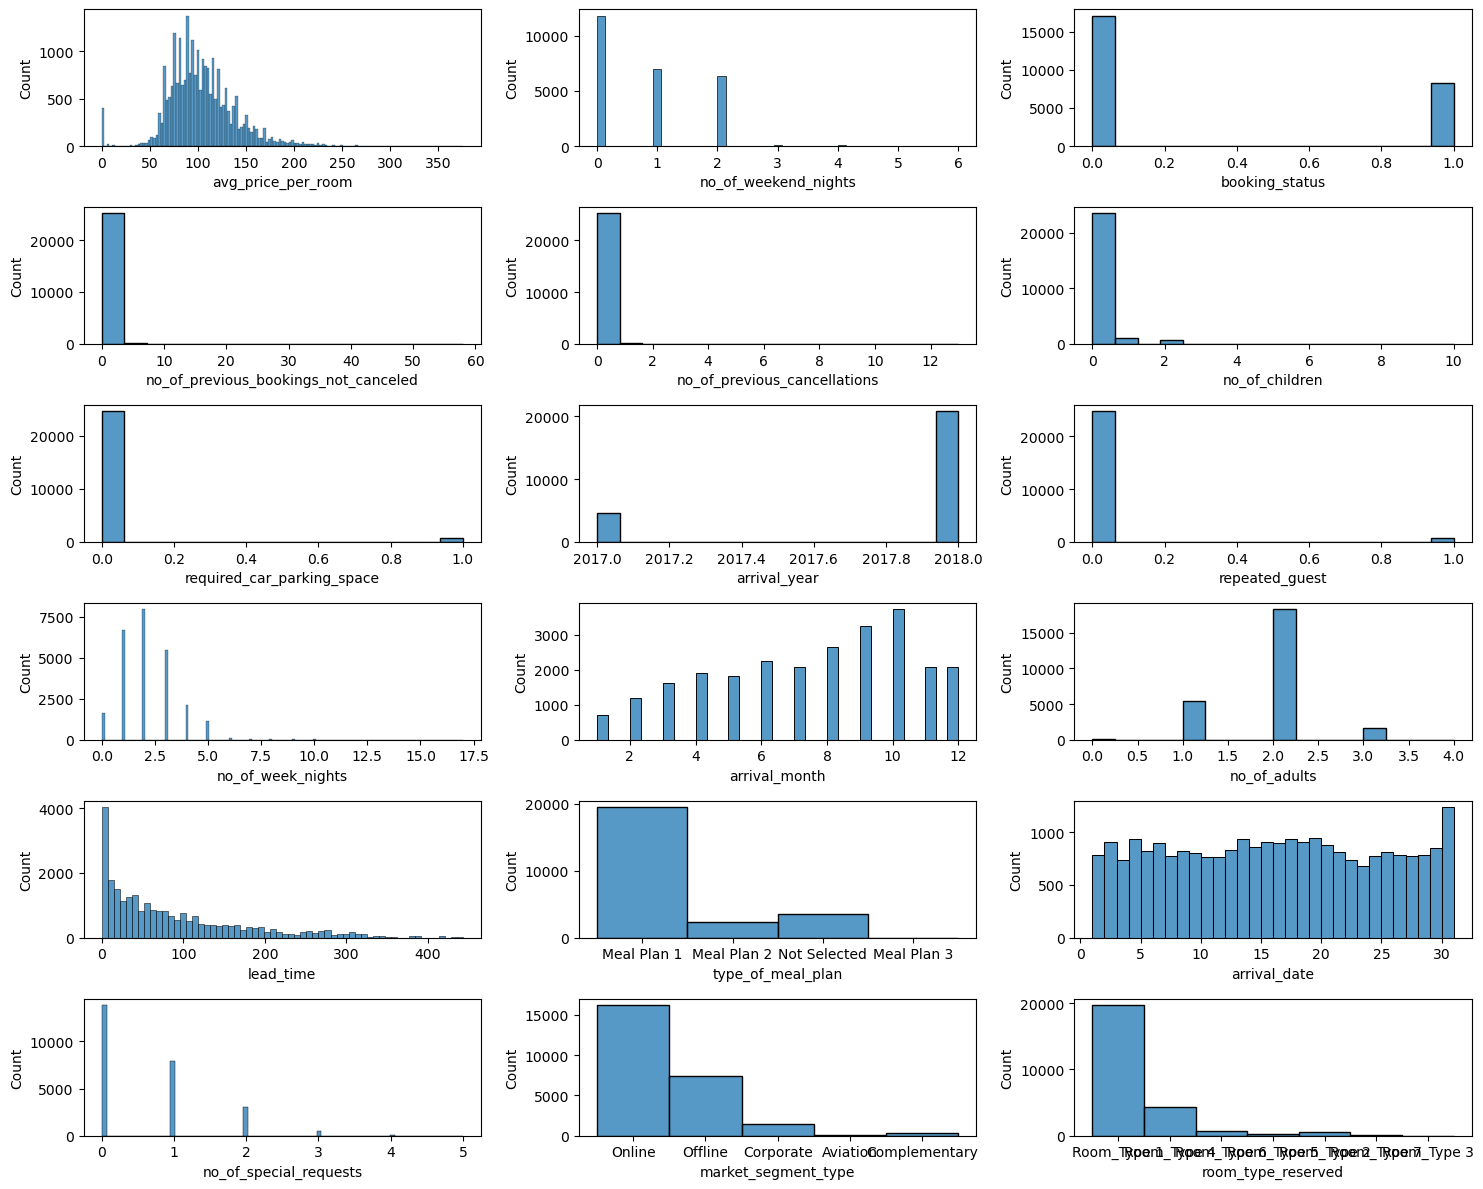

In [7]:
# 데이터 분포 확인: 단순 해당 feature에 대해서
fig, axes = plt.subplots(6, 3, figsize=(15, 12))
for idx, val in enumerate(list(set(train.columns))):
    sns.histplot(data=train, x=val, ax=axes[idx // 3, idx % 3], stat='count')
    plt.xlabel = val
plt.tight_layout()
plt.show()

features중 뚜렷한 특징을 보이는 features는 lead_time, avg_price_per_room 정도이다.

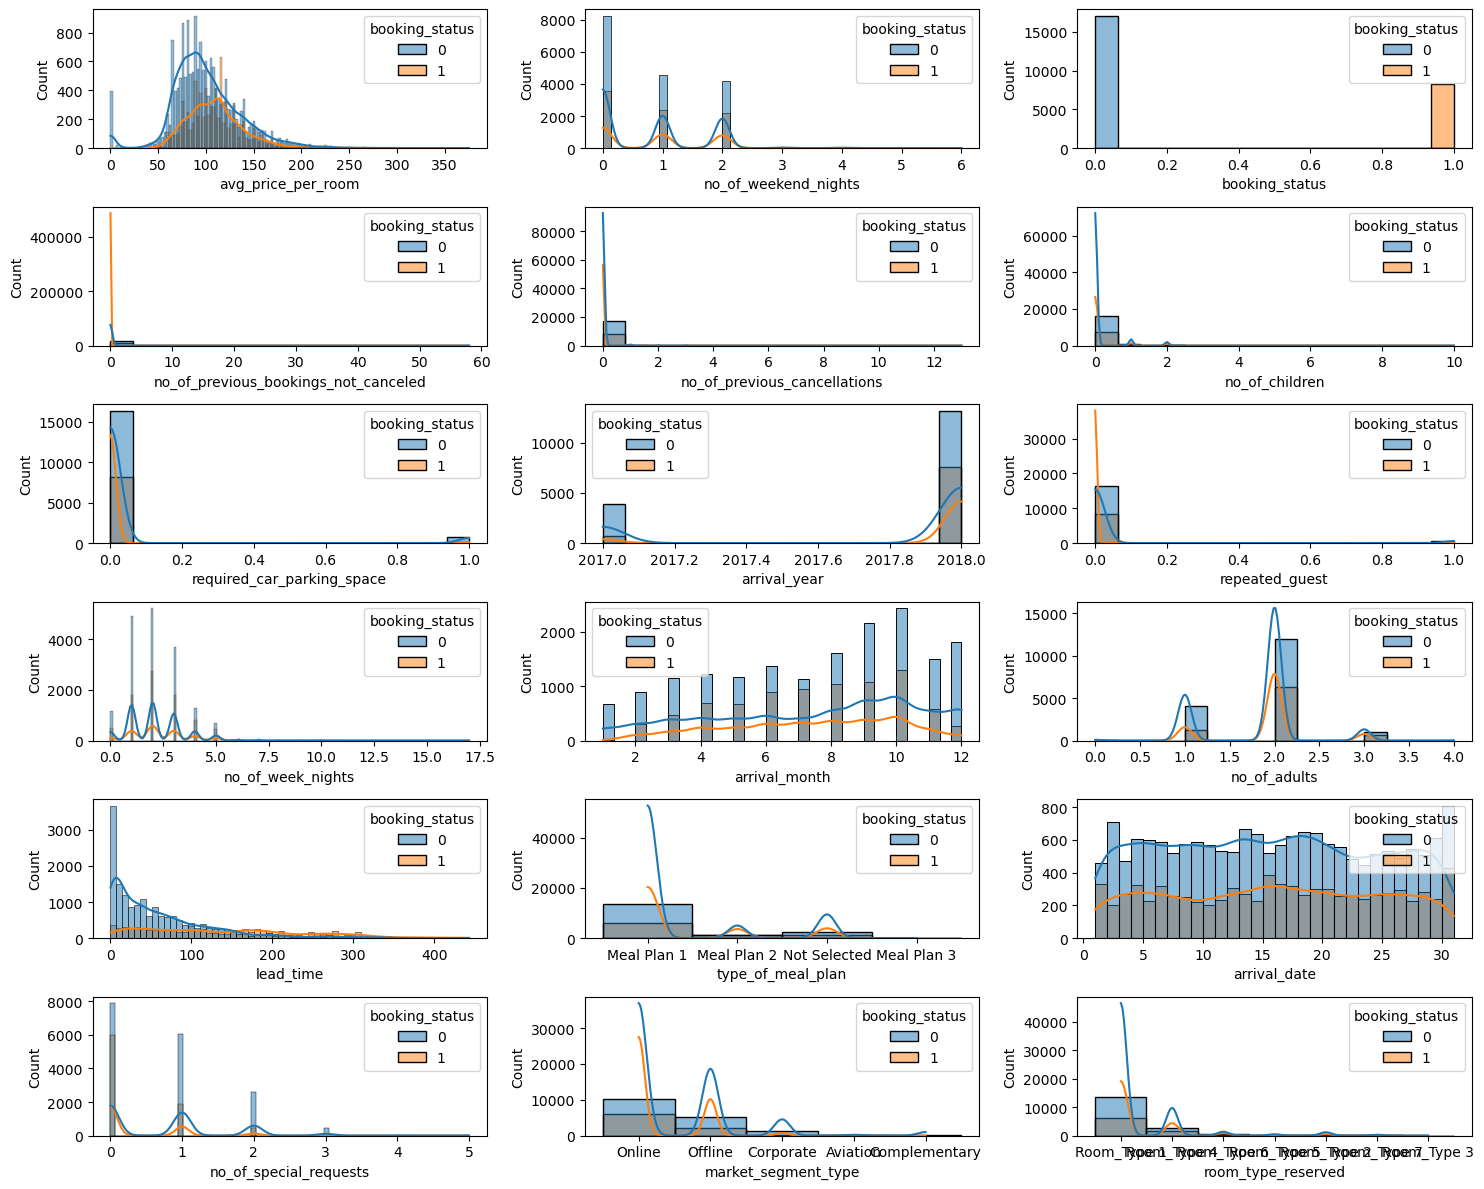

In [8]:
# 위와 동일한 표에서 'booking_status'과의 관계를 추가로 나타냄
fig, axes = plt.subplots(6, 3, figsize=(15,12))
for idx, val in enumerate(list(set(train.columns))):
    sns.histplot(data=train, x=val, ax=axes[idx // 3, idx % 3],stat='count', hue='booking_status', kde=True)
    plt.xlabel = val
fig.tight_layout()
plt.show()

features중 booking_status와 연관성을 보이는 것은 lead_time, market_segment_type, room_type_reserved, avg_price_per_room, required_car_parking_space, type_of_meal_plan, no_of_week_nights, no_of_special_requests 정도이다.

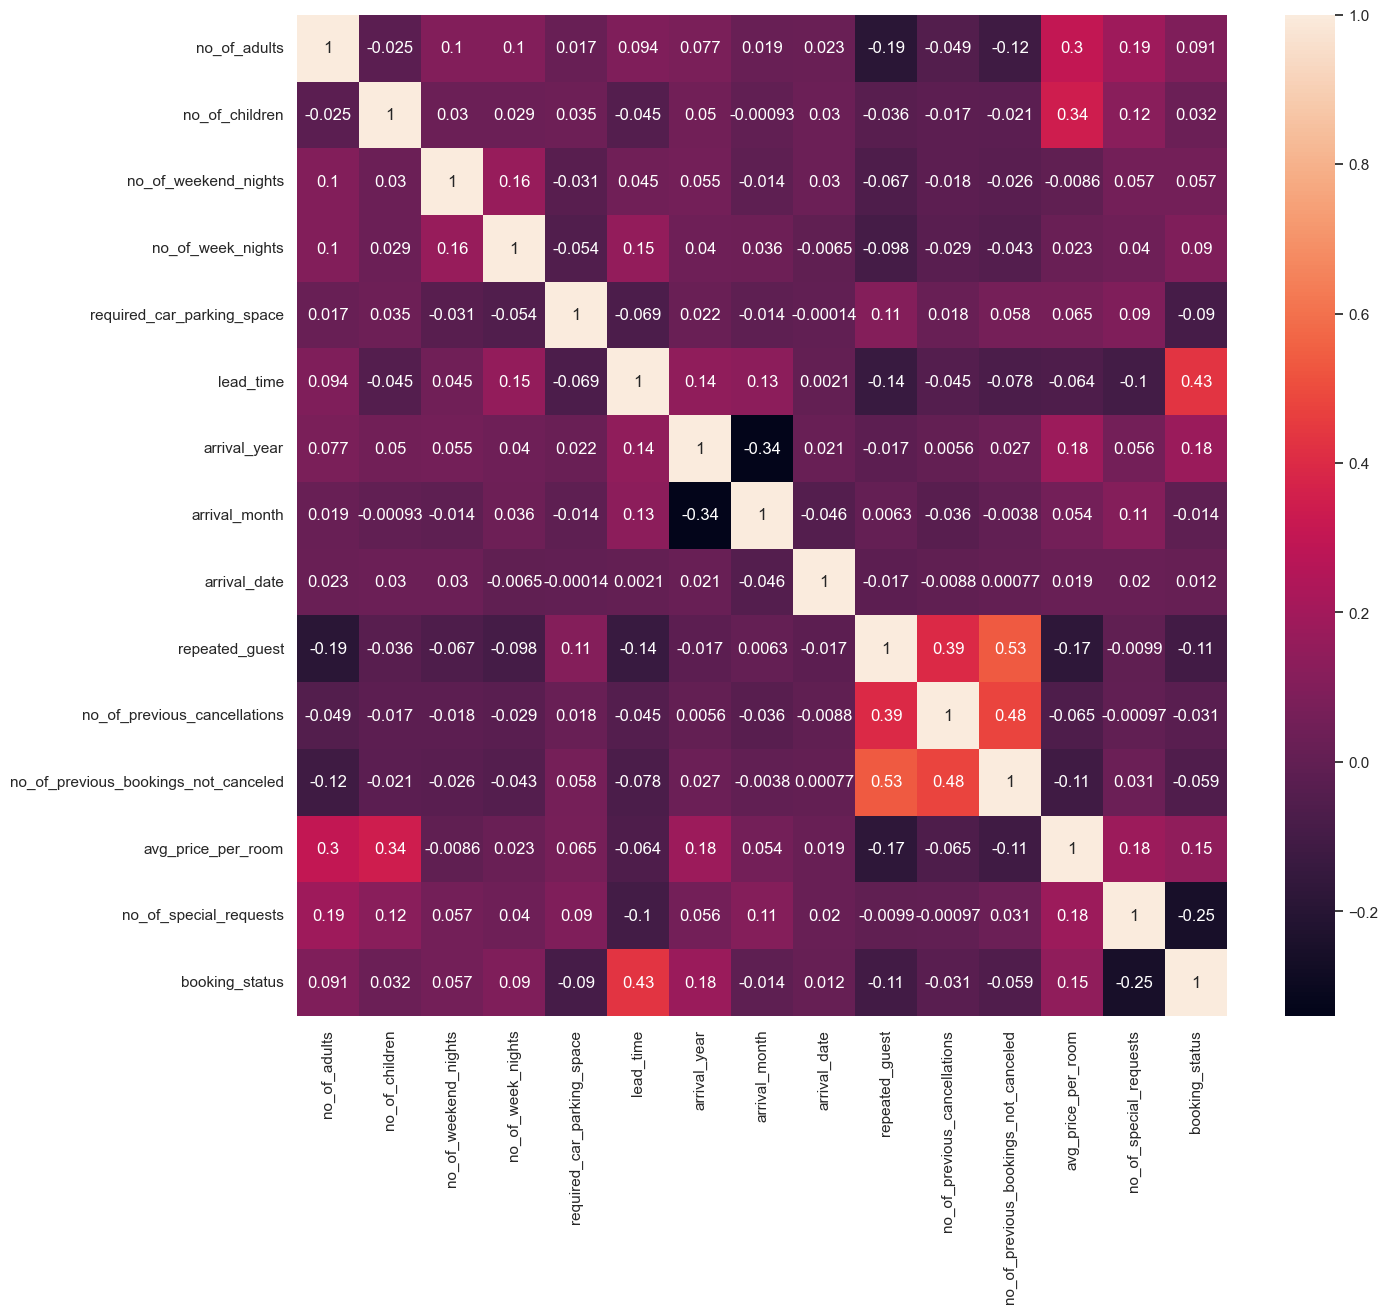

In [9]:
# heatmap으로 각 feature간의 상관관계 확인
sns.set(rc={'figure.figsize':(15, 13)}) 
correlation_matrix = train.corr()
sns.heatmap(data=correlation_matrix, annot=True) 
plt.show()

In [10]:
# 우리의 target값인 booking_status을 기준으로 상관관계 정렬
correlation = train.corr()['booking_status'].abs().sort_values(ascending = False)
correlation

booking_status                          1.000000
lead_time                               0.432341
no_of_special_requests                  0.254901
arrival_year                            0.175495
avg_price_per_room                      0.145585
repeated_guest                          0.106916
no_of_adults                            0.091378
required_car_parking_space              0.090402
no_of_week_nights                       0.090325
no_of_previous_bookings_not_canceled    0.058706
no_of_weekend_nights                    0.057094
no_of_children                          0.031683
no_of_previous_cancellations            0.030817
arrival_month                           0.014238
arrival_date                            0.011965
Name: booking_status, dtype: float64

lead_time이 0.432341을 기록하여 booking_status을 결정하는데 가장 중요한 영향을 미친다고 판단할 수 있다. no_of_special_requests, arrival_year 등의 feature가 그 뒤를 잇는다.

### 2-2) feature 처리(1) - categorical
dataset를 확인해보면 type_of_meal_plan, room_type_reserved, market_segment_type은 object type를 가진다. 이러한 값을 정수형(int)로 바꾸어준다.

In [11]:
# categorical features 탐색
cat_cols = [col for col in train.columns if train[col].dtype == object]
cat_cols

['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']

#### 1) type_of_meal_plan
항목의 수량이 많은 순서대로 0부터 할당하되, 'Meal Plan 3'은 수가 너무 적은 관계로 데이터의 비중이 가장 큰 'Meal Plan 1'에 사상

In [12]:
train['type_of_meal_plan'].value_counts()

Meal Plan 1     19492
Not Selected     3560
Meal Plan 2      2338
Meal Plan 3         2
Name: type_of_meal_plan, dtype: int64

In [13]:
meal_mapping = {
    'Meal Plan 1': 0, 'Meal Plan 2': 1, 'Not Selected': 2, 'Meal Plan 3': 0
}

for data in [train, test]:
    data['type_of_meal_plan'] = data['type_of_meal_plan'].map(meal_mapping)

#### 2. room_type_reserved

In [14]:
train['room_type_reserved'].value_counts()

Room_Type 1    19684
Room_Type 4     4242
Room_Type 6      667
Room_Type 2      498
Room_Type 5      186
Room_Type 7      111
Room_Type 3        4
Name: room_type_reserved, dtype: int64

In [15]:
roomType_mapping = {
    'Room_Type 1': 0, 'Room_Type 4': 1, 'Room_Type 6': 2, 'Room_Type 2': 3, 'Room_Type 5': 4, 'Room_Type 7': 5, 'Room_Type 3': 6
}

for data in [train, test]:
    data['room_type_reserved'] = data['room_type_reserved'].map(roomType_mapping)

#### 3. market_segment_type

In [16]:
train['market_segment_type'].value_counts()

Online           16210
Offline           7398
Corporate         1427
Complementary      272
Aviation            85
Name: market_segment_type, dtype: int64

In [17]:
marketType_mapping = {
    'Online': 0, 'Offline': 1, 'Corporate': 2, 'Complementary': 3, 'Aviation': 4
}

for data in [train, test]:
    data['market_segment_type'] = data['market_segment_type'].map(marketType_mapping)

In [18]:
# 변경사항 확인
train[cat_cols].head()

,type_of_meal_plan,room_type_reserved,market_segment_type
0,0,0,0
1,0,0,0
2,0,1,0
3,0,0,1
4,0,0,0


### 2-2) feature 처리(2) - numerical
* 이상치 제거
* feature 생성
* 정규화

In [19]:
# train data 중 cat_cols에 들어가 있지 않은 column: numerical
num_cols = [col for col in train.columns if col not in cat_cols]

# booking_status는 target이므로 제외
num_cols.remove('booking_status')

num_cols

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests']

In [20]:
# date와 관련된 column은 따로 빼둠
date = ['arrival_year', 'arrival_month', 'arrival_date']

for col in date:
    num_cols.remove(col)

#### 1. 이상치 제거

In [21]:
# numerical 데이터 확인
train[num_cols].describe().T.style

,count,mean,std,min,25%,50%,75%,max
no_of_adults,25392.000000,1.845069,0.519044,0.000000,2.000000,2.000000,2.000000,4.000000
no_of_children,25392.000000,0.105151,0.401900,0.000000,0.000000,0.000000,0.000000,10.000000
no_of_weekend_nights,25392.000000,0.810137,0.867761,0.000000,0.000000,1.000000,2.000000,6.000000
no_of_week_nights,25392.000000,2.201323,1.396599,0.000000,1.000000,2.000000,3.000000,17.000000
required_car_parking_space,25392.000000,0.031348,0.174261,0.000000,0.000000,0.000000,0.000000,1.000000
lead_time,25392.000000,85.411508,85.745937,0.000000,17.000000,58.000000,127.000000,443.000000
repeated_guest,25392.000000,0.025165,0.156630,0.000000,0.000000,0.000000,0.000000,1.000000
no_of_previous_cancellations,25392.000000,0.023905,0.378652,0.000000,0.000000,0.000000,0.000000,13.000000
no_of_previous_bookings_not_canceled,25392.000000,0.156191,1.818933,0.000000,0.000000,0.000000,0.000000,58.000000
avg_price_per_room,25392.000000,103.485770,35.067053,0.000000,80.750000,99.865000,120.150000,375.500000


lead_time, avg_price_per_room에서 이상치가 감지됨

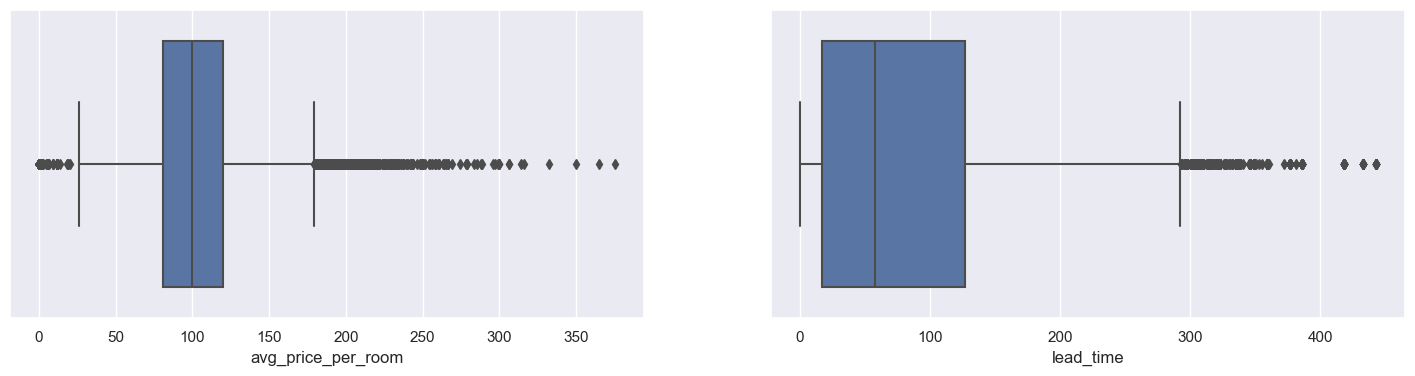

In [22]:
# boxplot를 그림으로서 해당 feature의 분포 및 이상치 확인
outliers_col = ['avg_price_per_room', 'lead_time']

fig, axis = plt.subplots(1, 2, figsize=(18,4))
ax = axis.flatten()

for i, fea in enumerate(outliers_col): 
    sns.boxplot(data=train, x=train[fea], ax=axis[i])

* avg_price_per_room: 350부터 outlier로 판정
* lead_time: 400부터 outlier로 판정

두 feature에서 avg_price_per_room, lead_time은 각각 350, 400정도부터 이상치로 판단이 되지만 이상치를 제거하지 않고 학습한 모델이 이상치를 제거하고 학습시킨 모델의 결과보다 성능이 더 나아 이상치를 제거하지 않았음.

In [23]:
# 이상치 감지, 하지만 제거하지 않음
# train = train[train['avg_price_per_room'] < 340]
# train = train[train['lead_time'] < 400]

#### 2. feature 생성
* no_of_total_nights: 숙박을 한 총 일 수
* no_of_total_guests: 총 손님의 수
* total_booking: 전체 에약 횟수
* total_cost: 총 숙박비

In [24]:
for data in [train, test]:

    # no_of_total_nights = no_of_weekend_nights + no_of_week_nights
    data['no_of_total_nights'] = data['no_of_weekend_nights'] + data['no_of_week_nights']

    # no_of_total_guests = no_of_adults + no_of_children
    data['no_of_total_guests'] = data['no_of_adults'] + data['no_of_children']

    # total_bookings = no_of_previous_cancellations + no_of_previous_bookings_not_canceled
    data['total_bookings'] = data['no_of_previous_cancellations'] + data['no_of_previous_bookings_not_canceled']

    # total_cost = no_of_total_nights * avg_price_per_room
    data['total_cost'] = data['no_of_total_nights'] * data['avg_price_per_room']

기존의 feature를 합쳐서 만든 새로운 feature가 기존의 feature를 합치기 전보다 booking_status과의 상관정도가 더 높을지 아닐지 판단하기 위해 이전 column은 삭제하지 않았음. 이후 target 값인 booking_status과의 상관계수 판단 후 선택적으로 삭제할 예정임.

In [25]:
# train 데이터 확인
train[num_cols].describe().T.style

,count,mean,std,min,25%,50%,75%,max
no_of_adults,25392.000000,1.845069,0.519044,0.000000,2.000000,2.000000,2.000000,4.000000
no_of_children,25392.000000,0.105151,0.401900,0.000000,0.000000,0.000000,0.000000,10.000000
no_of_weekend_nights,25392.000000,0.810137,0.867761,0.000000,0.000000,1.000000,2.000000,6.000000
no_of_week_nights,25392.000000,2.201323,1.396599,0.000000,1.000000,2.000000,3.000000,17.000000
required_car_parking_space,25392.000000,0.031348,0.174261,0.000000,0.000000,0.000000,0.000000,1.000000
lead_time,25392.000000,85.411508,85.745937,0.000000,17.000000,58.000000,127.000000,443.000000
repeated_guest,25392.000000,0.025165,0.156630,0.000000,0.000000,0.000000,0.000000,1.000000
no_of_previous_cancellations,25392.000000,0.023905,0.378652,0.000000,0.000000,0.000000,0.000000,13.000000
no_of_previous_bookings_not_canceled,25392.000000,0.156191,1.818933,0.000000,0.000000,0.000000,0.000000,58.000000
avg_price_per_room,25392.000000,103.485770,35.067053,0.000000,80.750000,99.865000,120.150000,375.500000


#### 3. 정규화

일단 내가 했던데로 하고, 파일 하나 다시 파서 정규화 방법 다르게 시도해보기(sklearn에서 제공하는..)

In [26]:
train.var()

no_of_adults                                0.269407
no_of_children                              0.161524
no_of_weekend_nights                        0.753010
no_of_week_nights                           1.950488
type_of_meal_plan                           0.514162
required_car_parking_space                  0.030367
room_type_reserved                          0.571573
lead_time                                7352.365766
arrival_year                                0.147944
arrival_month                               9.361158
arrival_date                               76.218207
market_segment_type                         0.464285
repeated_guest                              0.024533
no_of_previous_cancellations                0.143377
no_of_previous_bookings_not_canceled        3.308517
avg_price_per_room                       1229.698231
no_of_special_requests                      0.618668
booking_status                              0.219736
no_of_total_nights                          3.

분산이 가장 높은 lead_time, avg_price_per_room, total_cost에 대해서 log scale로 변환

In [27]:
scale_col = ['lead_time', 'avg_price_per_room', 'total_cost']

for data in [train, test]:
    data['lead_time'] = np.log(data['lead_time'] + 1)
    data['avg_price_per_room'] = np.log(data['avg_price_per_room'] + 1)
    data['total_cost'] = np.log(data['total_cost'] + 1)   


In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25392 entries, 0 to 25391
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          25392 non-null  int64  
 1   no_of_children                        25392 non-null  int64  
 2   no_of_weekend_nights                  25392 non-null  int64  
 3   no_of_week_nights                     25392 non-null  int64  
 4   type_of_meal_plan                     25392 non-null  int64  
 5   required_car_parking_space            25392 non-null  int64  
 6   room_type_reserved                    25392 non-null  int64  
 7   lead_time                             25392 non-null  float64
 8   arrival_year                          25392 non-null  int64  
 9   arrival_month                         25392 non-null  int64  
 10  arrival_date                          25392 non-null  int64  
 11  market_segment_

## 3. feature 선택

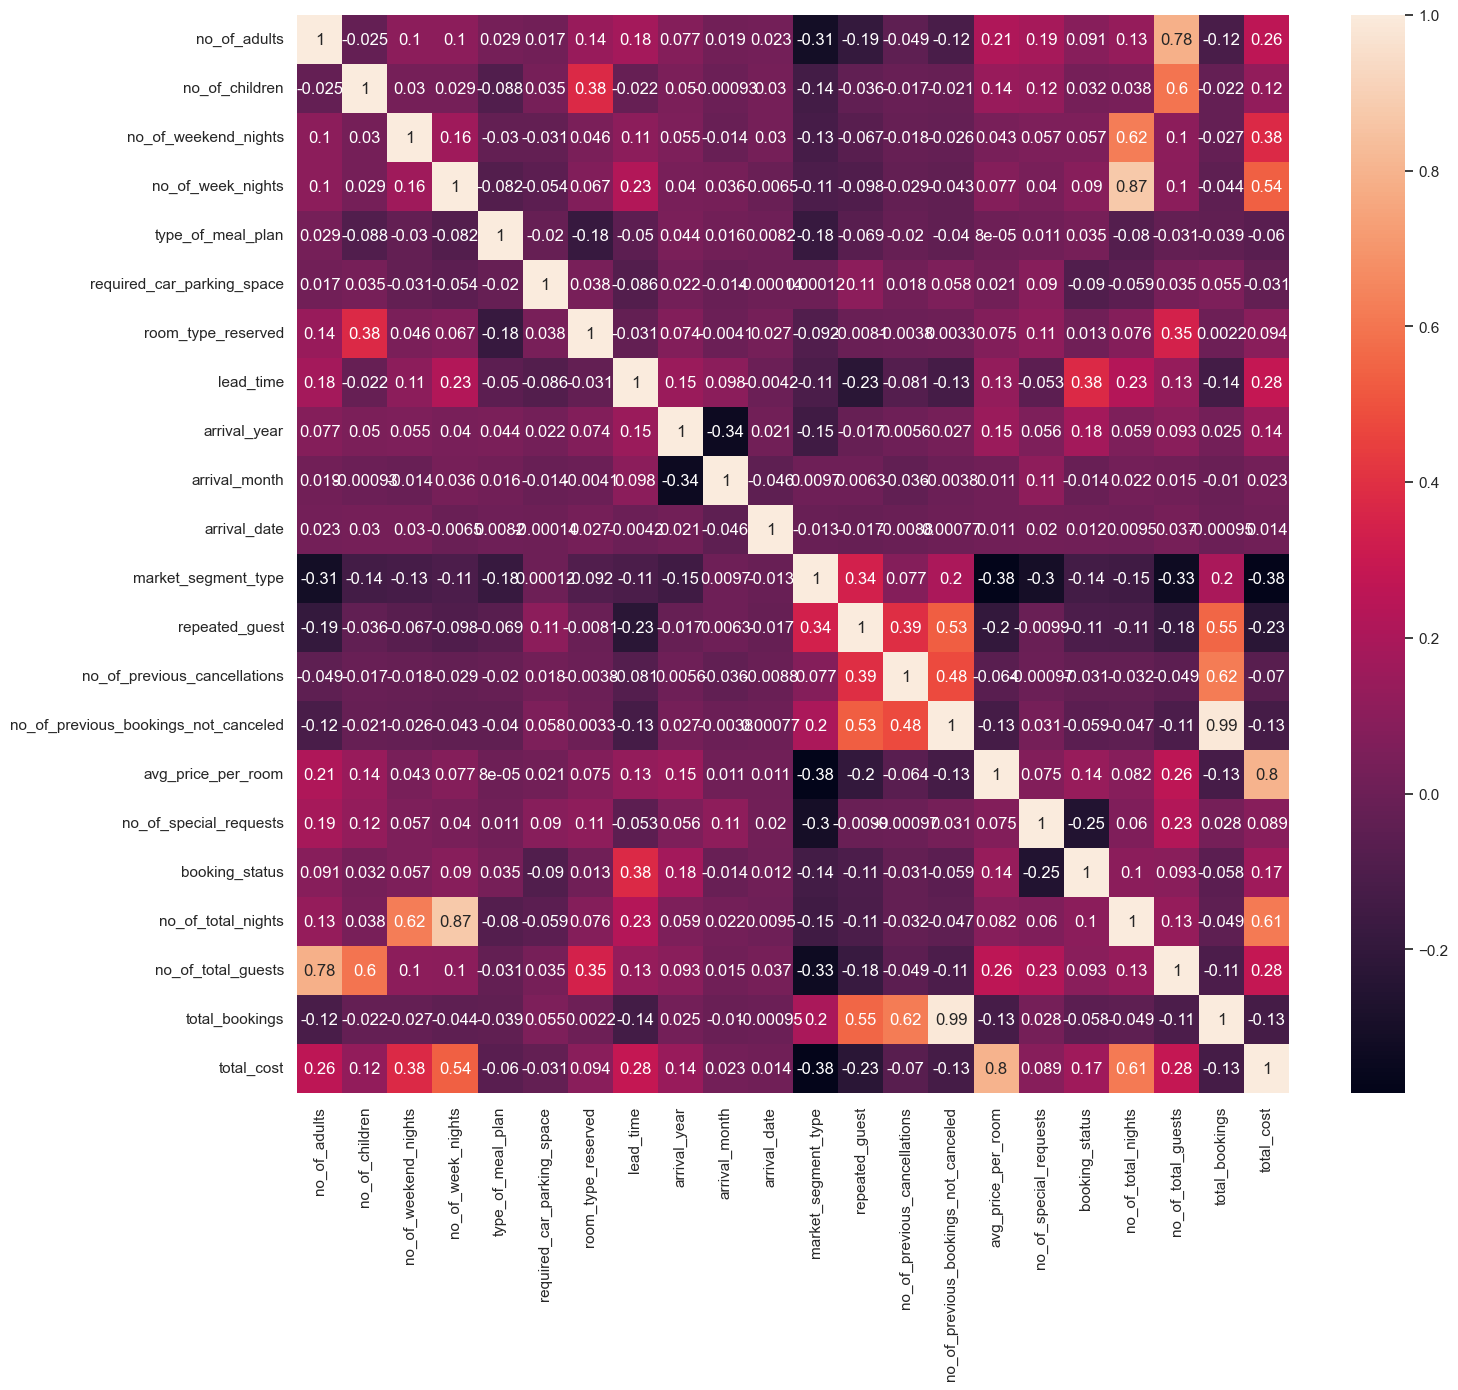

In [29]:
sns.set(rc={'figure.figsize':(16, 14)}) 
correlation_matrix = train.corr()
sns.heatmap(data=correlation_matrix, annot=True) 
plt.show()

In [30]:
correlation = train.corr()['booking_status'].abs().sort_values(ascending = False)
correlation

booking_status                          1.000000
lead_time                               0.376092
no_of_special_requests                  0.254901
arrival_year                            0.175495
total_cost                              0.166556
avg_price_per_room                      0.140024
market_segment_type                     0.137250
repeated_guest                          0.106916
no_of_total_nights                      0.099812
no_of_total_guests                      0.092777
no_of_adults                            0.091378
required_car_parking_space              0.090402
no_of_week_nights                       0.090325
no_of_previous_bookings_not_canceled    0.058706
total_bookings                          0.058412
no_of_weekend_nights                    0.057094
type_of_meal_plan                       0.034755
no_of_children                          0.031683
no_of_previous_cancellations            0.030817
arrival_month                           0.014238
room_type_reserved  

lead_time  no_of_special_requests arrival_year   avg_price_per_room  repeated_guest   no_of_total_nights no_of_adults  required_car_parking_space  no_of_week_nights   no_of_previous_bookings_not_canceled  만 사용했음

In [31]:
feature_drop = [
    'arrival_date',
    'room_type_reserved', 
    'arrival_month',
    'no_of_previous_cancellations', 
    'no_of_children', 
    'type_of_meal_plan', 
    'no_of_weekend_nights', 
    'total_bookings', 
    'no_of_previous_bookings_not_canceled',
    # 'no_of_total_guests', 
    'no_of_adults',
    # 'total_cost',
    'avg_price_per_room'
]

train.drop(feature_drop, axis=1, inplace=True)
test.drop(feature_drop, axis=1, inplace=True)

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25392 entries, 0 to 25391
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   no_of_week_nights           25392 non-null  int64  
 1   required_car_parking_space  25392 non-null  int64  
 2   lead_time                   25392 non-null  float64
 3   arrival_year                25392 non-null  int64  
 4   market_segment_type         25392 non-null  int64  
 5   repeated_guest              25392 non-null  int64  
 6   no_of_special_requests      25392 non-null  int64  
 7   booking_status              25392 non-null  int64  
 8   no_of_total_nights          25392 non-null  int64  
 9   no_of_total_guests          25392 non-null  int64  
 10  total_cost                  25392 non-null  float64
dtypes: float64(2), int64(9)
memory usage: 2.1 MB


In [33]:
train.head()

,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,market_segment_type,repeated_guest,no_of_special_requests,booking_status,no_of_total_nights,no_of_total_guests,total_cost
0,3,0,5.303305,2018,0,0,0,1,4,2,5.899349
1,3,0,4.382027,2018,0,0,1,1,4,2,5.899349
2,4,0,4.369448,2018,0,0,1,0,5,2,6.211102
3,0,0,4.127134,2017,1,0,0,0,2,2,5.209486
4,4,0,5.308268,2018,0,0,3,0,4,3,5.799456


In [34]:
test.head()

,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,market_segment_type,repeated_guest,no_of_special_requests,no_of_total_nights,no_of_total_guests,total_cost
0,0,0,1.386294,2017,0,0,3,1,3,4.510860
1,2,0,2.302585,2018,1,0,0,3,2,4.990501
2,2,0,3.218876,2018,0,0,1,4,2,5.944897
3,3,0,3.178054,2018,0,0,0,3,2,5.950669
4,2,0,2.302585,2018,0,0,2,2,3,6.001415


## 4. model 선택

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [36]:
target = train['booking_status']
train.drop(['booking_status'], axis=1, inplace=True)

### 1. kNN

In [39]:
knn = KNeighborsClassifier(
    n_neighbors=33,
    # leaf_size=10,
    weights='distance',
    p=1,
    metric='manhattan'
)
scoring = 'accuracy'
# knn.fit(new_train, target)
score = cross_val_score(knn, train, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.87086614 0.86850394 0.87042143 0.86766443 0.87396613 0.88144939
 0.86845215 0.86569516 0.87632926 0.87160299]


In [40]:
# kNN score
round(np.mean(score) * 100, 2)

87.15